<a href="https://colab.research.google.com/github/DesiPilla/demographics-voterid-turnout/blob/master/Group_2_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

!pip install geopandas
import geopandas as gp

from statsmodels.stats.weightstats import ztest
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import accuracy_score, fowlkes_mallows_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Datasets

In [0]:
# Load full datasets (only one nan row)
data = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data.shp').dropna()
data_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data_mainland.shp').dropna()
data_no_ak = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data_no_ak.shp').dropna()

In [0]:
# Load demographic datasets
demgeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/demgeo.shp')
demgeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/demgeo_mainland.shp')

# Load voter ID datasets
votgeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/votgeo.shp')
votgeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/votgeo_mainland.shp')

# Load turnout datasets
turngeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/turngeo.shp')
turngeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/turngeo_mainland.shp')

## Data Preparation

In [0]:
feat = data_no_ak.drop(columns=['county_fip', 'turnout', 'county_nam', 'state_abbr', 'VEP', 'STATEFP', 'ElectoralV', 'VoterIDL_1', 'geometry'])
feat_st = (feat - feat.mean()) / feat.std()

target = data_no_ak.turnout
target[target > 1] = 1
target_st = (target - target.mean()) / target.std()

X_train, X_test, y_train, y_test = train_test_split(feat_st, target_st, test_size=0.25, random_state=667)

In [6]:
# Get the voting-eligible persons in each county and state for weighting
vep = np.array(data_no_ak.VEP).reshape(-1, 1)
state_vep = data_no_ak[['STATEFP', 'VEP']].groupby('STATEFP').mean().values

# Weight the features by VEP
feat_wt = np.multiply(vep, feat)
target_wt = np.multiply(vep, pd.DataFrame(target))

# Group counties by state
feat_wt['STATEFP'] = data_no_ak.STATEFP.values
target_wt['STATEFP'] = data_no_ak.STATEFP.values

# Standardize by VEP and normalize data
feat_states = feat_wt.groupby('STATEFP').mean() / state_vep
feat_states_st = (feat_states - feat_states.mean()) / feat_states.std()
target_states = target_wt.groupby('STATEFP').mean() / state_vep
target_states_st = (target_states - target_states.mean()) / target_states.std()
feat_states['turnout'] = target_states
feat_states_st['turnout'] = target_states_st
feat_states['VoterIDLaw'] = data_no_ak.groupby('STATEFP').max().VoterIDLaw.astype(int)
feat_states_st['VoterIDLaw'] = data_no_ak.groupby('STATEFP').max().VoterIDLaw.astype(int)
feat_states['VoterIDL_1'] = data_no_ak.groupby('STATEFP').max().VoterIDL_1
feat_states_st['VoterIDL_1'] = data_no_ak.groupby('STATEFP').max().VoterIDL_1

feat_states.head()

,MedianHous,CollegeDeg,34_younger,35_to_59,60_older,MedianAge,not_white,unemployed,VoterIDLaw,turnout,VoterIDL_1
STATEFP,,,,,,,,,,,
1,44500.447866,0.427330,0.295730,0.430763,0.273508,38.431364,0.310882,0.060625,3,0.559100,Non-strict photo ID
4,50351.539976,0.441120,0.308040,0.413452,0.278509,37.161379,0.214346,0.052951,4,0.410742,Strict non-photo ID
5,41878.943767,0.412084,0.298390,0.422407,0.279203,38.031863,0.219146,0.035405,2,0.492889,Non-strict non-photo ID
6,63447.423815,0.503290,0.327991,0.438212,0.233796,35.927705,0.382703,0.053449,1,0.408960,No ID requirement
8,61635.303653,0.541660,0.321136,0.442896,0.235968,36.611010,0.157334,0.031028,2,0.635854,Non-strict non-photo ID


# Non-Machine Learning Analysis

The cells below highlight the analyses conducted that did not have machine learning methods involved. We believe these statistical analyses will strongly complement the machine learning results we find later on.

## Classify "disadvantaged" counties

We will weight certain features to classify counties as either “disadvantaged” or “non-disadvantaged”.

The four features being used to create this "disadvantage index" are the following:
 * `1 - MedieanHous`: the smaller the median househole income, the more disadvantaged the county is.
 * `1 - CollegeDeg`: the smaller the percentage of residents with a college degree, the more disadvantaged the county is.
 * `MedianAge`: the larger the median age, the more disadvantaged the county is.
 * `not_white`: the larger the minority population, the more disadvantaged the county is.

In [7]:
cols = ['MedianHous', 'CollegeDeg', 'MedianAge', 'not_white']

# Get county fips and geometry for future use
county_fip = data_no_ak.county_fip
geometry = data_no_ak.geometry

# Get features and standardize them
feat = data_no_ak[cols]
feat_st = (feat - feat.mean()) / feat.std()

# Orient the features so lower values correspond to more disadvantage
feat_st['MedianHous'] = 1 - feat_st['MedianHous']
feat_st['CollegeDeg'] = 1 - feat_st['CollegeDeg']

# sum across the features and weight equally
data_no_ak['disadvantage_index'] = feat_st.sum(axis=1) / 4
data_no_ak['disadvantage_index'] -= data_no_ak.disadvantage_index.min()
data_no_ak['disadvantage_index'] /= data_no_ak.disadvantage_index.max()
data_no_ak['disadvantaged'] = data_no_ak['disadvantage_index'] > data_no_ak['disadvantage_index'].quantile(0.85)

# Re-directionalize the Median Household Income and Median Age columns 
feat_st['MedianHous'] = 1 - feat_st['MedianHous']
feat_st['CollegeDeg'] = 1 - feat_st['CollegeDeg']

data_no_ak[['county_fip'] + cols + ['disadvantage_index', 'disadvantaged']].head()

,county_fip,MedianHous,CollegeDeg,MedianAge,not_white,disadvantage_index,disadvantaged
0,31039,50013.0,0.383511,43.6,0.039987,0.578743,False
1,31109,51830.0,0.517659,32.9,0.126604,0.416972,False
2,31129,40488.0,0.337133,49.2,0.020269,0.695995,False
3,31101,41781.0,0.360804,49.1,0.035232,0.681118,False
4,31137,50404.0,0.380159,42.0,0.029188,0.559238,False


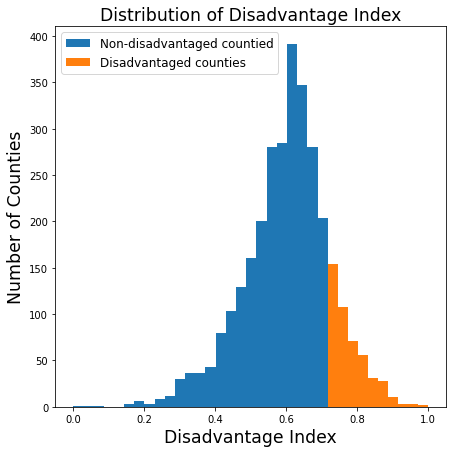

In [8]:
fig, ax = plt.subplots(figsize=(7, 7));
ax.hist(data_no_ak[~data_no_ak.disadvantaged].disadvantage_index, bins=25, label='Non-disadvantaged countied')
ax.hist(data_no_ak[data_no_ak.disadvantaged].disadvantage_index, bins=10, label='Disadvantaged counties')
ax.set_title('Distribution of Disadvantage Index', fontsize='xx-large')
ax.set_ylabel('Number of Counties', fontsize='xx-large')
ax.set_xlabel('Disadvantage Index', fontsize='xx-large')
ax.legend(fontsize='large')

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantage_index_hist.png', clobber=True)
fig.show();

**Figure:** The above histogram shows the distribution of counties based on their `Disadvantage Index`. Larger values signify a county is more disadvantaged, and vice versa. The counties labeled "disadvantaged" are those with a disadvantage index in the 85th percentile and above, implying they are the most disadvantaged.

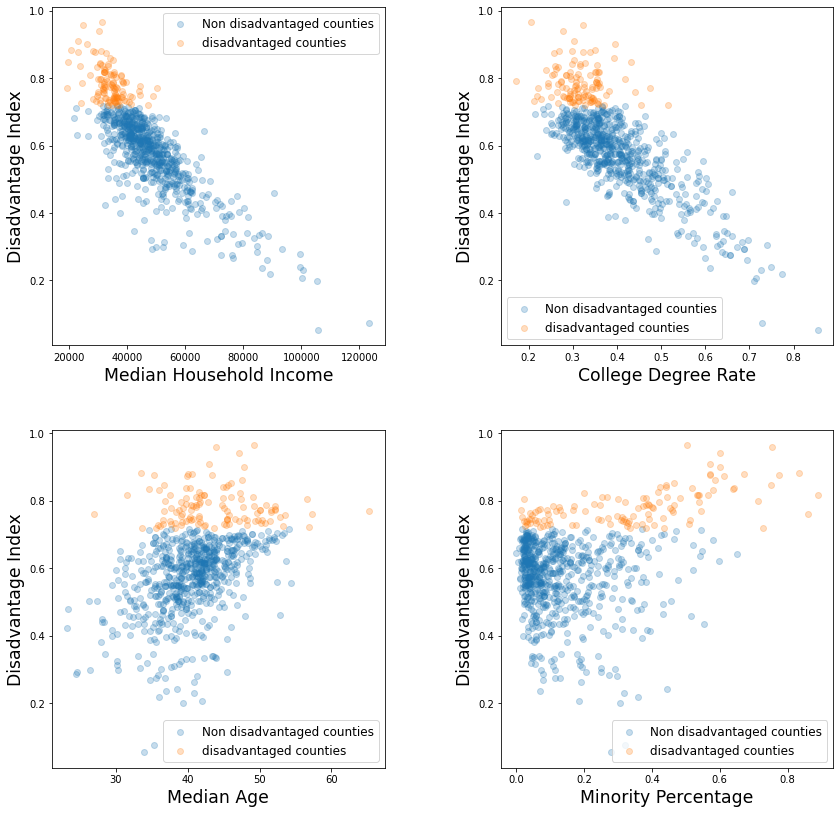

In [9]:
feat_names = ['Median Household Income', 'College Degree Rate', 'Median Age', 'Minority Percentage']
feat_labels = ['Median\nHousehold\nIncome', 'College\nDegree\nRate', 'Median Age', 'Minority\nPercentage']

r, c = 2, 2
fig, ax = plt.subplots(r, c, figsize=(7*c, 7*r))
for i in range(np.prod(ax.shape)):

    # Get index of counties in the bottom 25th percentile
    idx = data_no_ak.disadvantaged
    step = 4
    alpha = 0.25

    # Plot the counties, colored by their percentile
    ax[i // c][i % c].scatter(feat.values[~idx, i][::step], data_no_ak['disadvantage_index'][~idx][::step], alpha=alpha, label='Non disadvantaged counties')
    ax[i // c][i % c].scatter(feat.values[idx, i][::step], data_no_ak['disadvantage_index'][idx][::step], alpha=alpha, label='disadvantaged counties')

    ax[i // c][i % c].set_ylabel('Disadvantage Index', fontsize='xx-large')
    ax[i // c][i % c].set_xlabel(feat_names[i], fontsize='xx-large')
    ax[i // c][i % c].legend(fontsize='large')

fig.subplots_adjust(hspace=0.25, wspace=0.35)
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantage_index_correlations.png', clobber=True)
fig.show();

**Figure:** The above plots show how the disadvantage index correlates with the four different featers that comprise it. Only `Median Household Income` and `College Degree Rate` have an apparent correlation, even though all four features are equally weighted in the metric's calculation.

In [0]:
def make_bins(xcol, ycol, n_bins=4, df=data_no_ak):
    bins, means, serrs, labels = [], [], [], []

    for i in range(n_bins):
        # Get values in the i-th bin
        bot = i / n_bins
        top = (i + 1) / n_bins
        labels.append('{0:.0%} - {1:.0%}'.format(bot, top))

        idx = (df[xcol] > df[xcol].quantile(bot)) & (df[xcol] < df[xcol].quantile(top))

        # Get bin data
        bins.append(df[idx][ycol].values)
        means.append(np.mean(bins[i]))
        serrs.append(np.std(bins[i]) / len(bins[i])**0.5)

    return np.array(bins), means, serrs, labels

def split_by(split_col, ycol, df=data_no_ak):
    bins, means, serrs, labels = [], [], [], []

    for i, val in enumerate(sorted(df[split_col].unique())):
        # Get values with the label i
        labels.append('{0:.0f}'.format(i+1))
        bins.append(df[df[split_col] == val][ycol].values)
        means.append(np.mean(bins[i]))
        serrs.append(np.std(bins[i]) / len(bins[i])**0.5)

    return np.array(bins), means, serrs, labels

def plot_split(xcol, ycol='turnout', n_bins=4, xlabel=None, fig=None, ax=None, df=data_no_ak):
    binning = True
    if not n_bins:
        bins, means, serrs, labels = split_by(xcol, ycol, df=df)
        n_bins = len(bins)
        binning = False
    else:    
        bins, means, serrs, labels = make_bins(xcol, ycol, n_bins, df=df)

    # Plot the performance
    if not fig:
        fig, ax = plt.subplots(figsize=(2*n_bins, 5))

    # Make the plot
    ax.bar(np.arange(len(means)), means, edgecolor='white')
    ax.errorbar(np.arange(len(means)), means, yerr=serrs, fmt=',k', capsize=10)
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels, fontsize='large')

    if not binning:
        ax.set_xlabel(xlabel, fontsize='x-large')    
    else:
        ax.set_xlabel('Percentile Bins', fontsize='x-large')

    if ycol == 'turnout':
        ax.set_ylabel('Turnout Rate', fontsize='x-large')
        ax.set_ylim(0, 1)
        ax.set_title('Turnout Rate by {0}'.format(xlabel), fontsize='xx-large')
    elif ycol =='VoterIDLaw':
        ax.set_ylabel('Average Voter ID Law', fontsize='x-large')
        ax.set_title('Voter ID Law Strictness by {0}'.format(xlabel), fontsize='xx-large')
    fig.tight_layout()
    
    return fig

def print_ztest(sample1, sample2, target='turnout rate', alpha=0.05):

    z_statistic, pval = ztest(sample1,sample2)

    print('Null hypothesis: The two samlpes have the \033[1msame mean', target)
    print("\n\033[0mdisadvantaged mean value: {0:.4f}".format(np.mean(sample1)))
    print("non-disadvantaged mean value: {0:.4f}".format(np.mean(sample2)))

    print("\ndisadvantaged standard error: {0:.4f}".format(np.std(sample1) / len(sample1)**0.5))
    print("non-disadvantaged standard error: {0:.4f}".format(np.std(sample2) / len(sample2)**0.5))

    print("\np-value for {0:.4f} significance: {1:.2e}\033[1m".format(alpha, pval))
    if pval < alpha:
        print("we reject the null hypothesis")
    else:
        print("we fail to reject the null hypothesis")
    print('\033[0m\n\n')

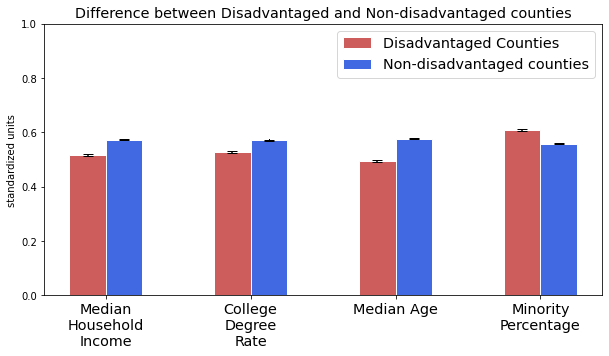

In [11]:
dis_means, non_dis_means = [], []
dis_serrs, non_dis_serrs = [], []
pvals = []

for c in cols:
    idx = data_no_ak[c] < data_no_ak[c].quantile(0.15)

    # Split the data into disadvantaged and non-disadvantaged
    dis = data_no_ak[idx].turnout.values
    non_dis = data_no_ak[~idx].turnout.values

    # Find the mean of each group
    dis_mean = np.mean(dis)
    dis_means.append(dis_mean)
    non_dis_mean = np.mean(non_dis)
    non_dis_means.append(non_dis_mean)

    # Fint the standard deviation of each group
    dis_serr = np.std(dis) / len(dis)**0.5
    dis_serrs.append(dis_serr)
    non_dis_serr = np.std(non_dis) / len(non_dis)**0.5
    non_dis_serrs.append(non_dis_serr)

    # Conduct a z-test on the two groups
    z_statistic, pval = ztest(dis,non_dis)
    pvals.append(pval)

# Set position of bar on X axis
barWidth = 0.25
x1 = np.arange(len(dis_means))
x2 = [x + barWidth for x in x1]

# Plot the performance
fig, ax = plt.subplots(figsize=(10, 5))

# Make the plot
ax.bar(x1, dis_means, color='indianred', width=barWidth, edgecolor='white', label='Disadvantaged Counties')
ax.errorbar(x1, dis_means, yerr=dis_serrs, fmt=',k', capsize=5)
ax.bar(x2, non_dis_means, color='royalblue', width=barWidth, edgecolor='white', label='Non-disadvantaged counties')
ax.errorbar(x2, non_dis_means, yerr=non_dis_serrs, fmt=',k', capsize=5)
ax.set_xticks((x1 + x2)/2)
ax.set_xticklabels(feat_labels, fontsize='x-large', rotation=0)
ax.set_ylim(0, 1)
ax.set_title('Difference between Disadvantaged and Non-disadvantaged counties', fontsize='x-large')
ax.set_ylabel('standardized units')
ax.legend(fontsize='x-large')

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/disadvantaged_conditional_turnouts.png', clobber=True)
fig.show();

**Figure:** The above figure shows that there are significant differences between disadvantaged and non-disdvantaged counties in the four major demographic categories. However, this is to be expected, as by definition the "disadvantaged" counties are taken from the lowest 15th percentile in each category.

In [12]:
print_ztest(dis, non_dis)

Null hypothesis: The two samlpes have the same mean turnout rate

disadvantaged mean value: 0.6071
non-disadvantaged mean value: 0.5572

disadvantaged standard error: 0.0039
non-disadvantaged standard error: 0.0019

p-value for 0.0500 significance: 1.47e-25
we reject the null hypothesis





## Conditional turnout rates and ANOVA

Below, the conditional Voter ID laws and turnout rates are examined. For each of the four main demographic categories listed above, the data was split into equally-sized bins. For Voter ID laws, the data was analyzed at the *state* level, while for turnout rates, the data was analyzed at the *county* level. This was chosen because Voter ID laws are state-wide regulations, and thus should be compared with state-wide demographic features. However, states do not have homogenoeus demographic compositions. For this reason, we believe it is best to analyze turnout rates at the county level. We are better able to get a more granular perspective on how demographic features related to turnout rates in the 2016 election this way.

In [0]:
def print_anova(xcol, ycol='turnout', n_bins=4, target='turnout rate', alpha=0.05, df=data_no_ak):
    if not n_bins:
        bins, means, stds, labels = split_by(xcol, ycol, df=df)
    else:    
        bins, means, stds, labels = make_bins(xcol, ycol, n_bins, df=df)
        
    F, p = f_oneway(*bins)

    print('Null hypothesis: The samlpes have the \033[1msame mean', target, '\033[0m')
    print("\np-value for {0:.4f} significance: {1:.2e}\033[1m".format(alpha, p))
    if p < alpha:
        print("we reject the null hypothesis")
    else:
        print("we fail to reject the null hypothesis")
    print('\033[0m')

Null hypothesis: The samlpes have the same mean Voter ID Strictness 

p-value for 0.0500 significance: 7.49e-01
we fail to reject the null hypothesis



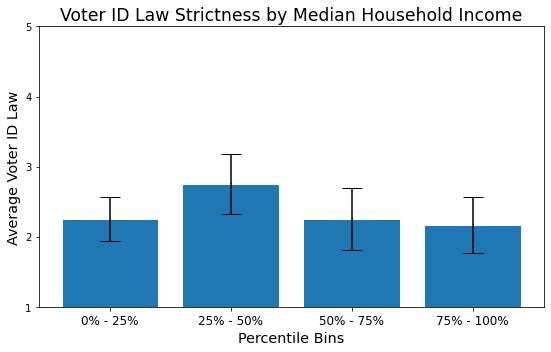

In [71]:
fig = plot_split('MedianHous', 'VoterIDLaw', 4, 'Median Household Income', df=feat_states);
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/medianhous_conditional_idlaw.png', clobber=True)
print_anova('MedianHous', 'VoterIDLaw', n_bins=4, target='Voter ID Strictness', df=feat_states)

**Figure:** The above figure shows that there were **not** significant differences between the Voter ID laws of states with different median household incomes. The states were split into four equally-sized quantiles, and their mean Voter ID law was plotted. Though there appear to be some differences, the sample size was not large enough to reduce the uncertainty in these measures.

Null hypothesis: The samlpes have the same mean turnout rate 

p-value for 0.0500 significance: 4.90e-91
we reject the null hypothesis



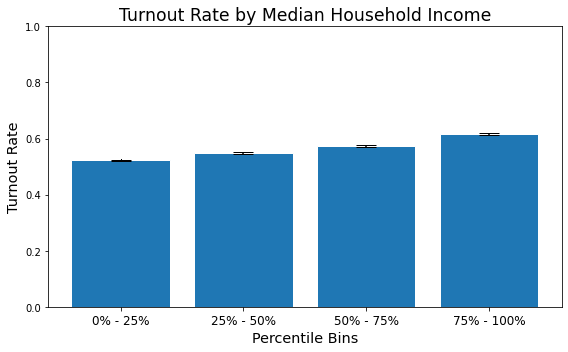

In [15]:
fig = plot_split('MedianHous', 'turnout', 4, 'Median Household Income');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/medianhous_conditional_turnouts.png', clobber=True)
print_anova('MedianHous', 'turnout', n_bins=4, target='turnout rate')

**Figure:** The above figure shows that there **were** significant differences between the turnout rate of counties with different median household incomes. The counties were split into four equally-sized quantiles, and their mean turnout rate was plotted. The chart shows a trend of increasing turnout rate in counties with an increase in median household income.

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 6.50e-01
we fail to reject the null hypothesis



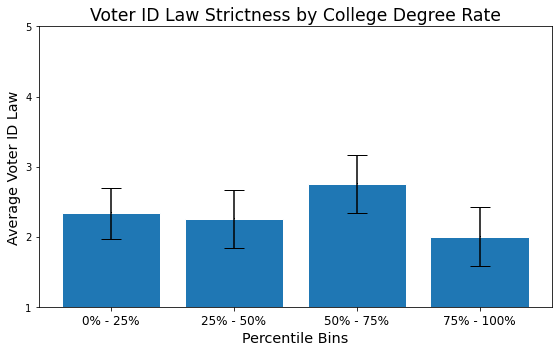

In [72]:
fig = plot_split('CollegeDeg', 'VoterIDLaw', 4, 'College Degree Rate', df=feat_states);
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/collegedeg_conditional_idlaw.png', clobber=True)
print_anova('CollegeDeg', 'VoterIDLaw', n_bins=4, target='Median Household Income', df=feat_states)

**Figure:** The above figure shows that there were **not** significant differences between the Voter ID laws of states with different college degree rates. The states were split into four equally-sized quantiles, and their mean Voter ID law was plotted. Though there appear to be some differences, the sample size was not large enough to reduce the uncertainty in these measures.

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 1.97e-46
we reject the null hypothesis



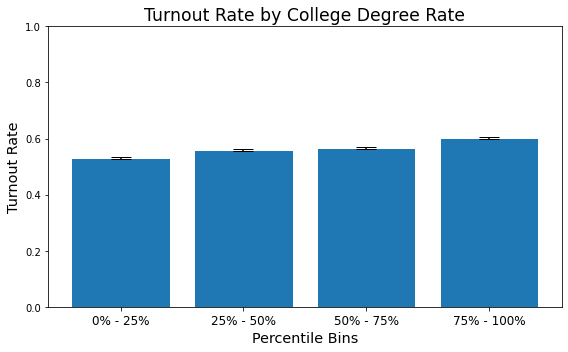

In [17]:
fig = plot_split('CollegeDeg', 'turnout', 4, 'College Degree Rate');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/collegedeg_conditional_turnouts.png', clobber=True)
print_anova('CollegeDeg', 'turnout', n_bins=4, target='Median Household Income')

**Figure:** The above figure shows that there **were** significant differences between the turnout rate of counties with different college degree rates. The counties were split into four equally-sized quantiles, and their mean turnout rate was plotted. The chart shows a trend of increasing turnout rate in counties with an increase in college degree rate.

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 8.87e-01
we fail to reject the null hypothesis



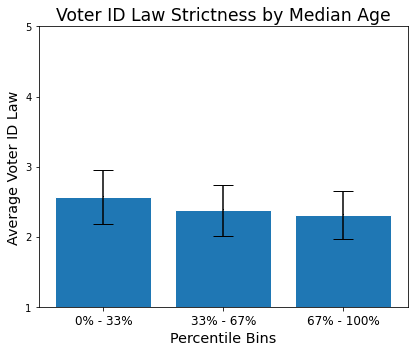

In [73]:
fig = plot_split('MedianAge', 'VoterIDLaw', 3, 'Median Age', df=feat_states);
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/medianage_conditional_idlaw.png', clobber=True)
print_anova('MedianAge', 'VoterIDLaw', n_bins=3, target='Median Household Income', df=feat_states)

**Figure:** The above figure shows that there were **not** significant differences between the Voter ID laws of states with different median ages. The states were split into three equally-sized bins, and their mean Voter ID law was plotted. Though there appear to be some differences, the sample size was not large enough to reduce the uncertainty in these measures.

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 5.18e-90
we reject the null hypothesis



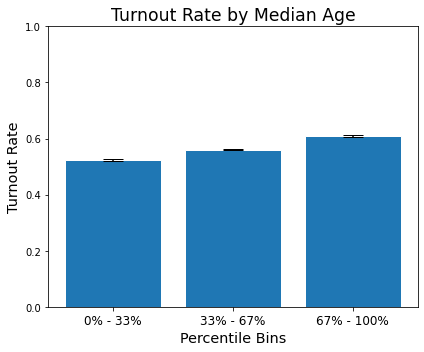

In [19]:
fig = plot_split('MedianAge', 'turnout', 3, 'Median Age');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/medianage_conditional_turnouts.png', clobber=True)
print_anova('MedianAge', 'turnout', n_bins=3, target='Median Household Income')

**Figure:** The above figure shows that there **were** significant differences between the turnout rate of counties with different median ages. The counties were split into three equally-sized bins, and their mean turnout rate was plotted. The chart shows a trend of increasing turnout rate in counties with an increase in median age.

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 6.03e-01
we fail to reject the null hypothesis



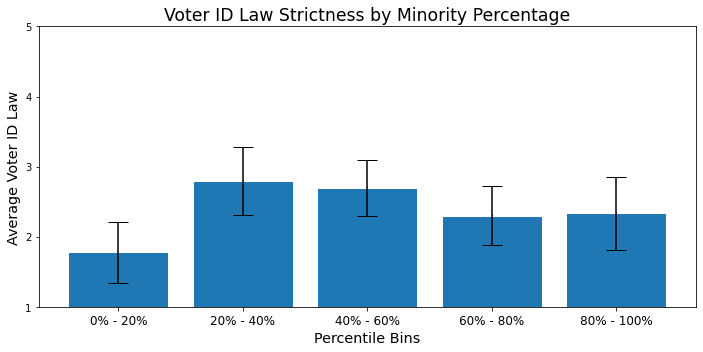

In [74]:
fig = plot_split('not_white', 'VoterIDLaw', 5, 'Minority Percentage', df=feat_states);
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/minority_conditional_idlaw.png', clobber=True)
print_anova('not_white', 'VoterIDLaw', n_bins=5, target='Median Household Income', df=feat_states)

**Figure:** The above figure shows that there were **not** significant differences between the Voter ID laws of states with different minority percentages. The states were split into five equally-sized bins, and their mean Voter ID law was plotted. Though there appear to be some differences, the sample size was not large enough to reduce the uncertainty in these measures.

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 5.28e-72
we reject the null hypothesis



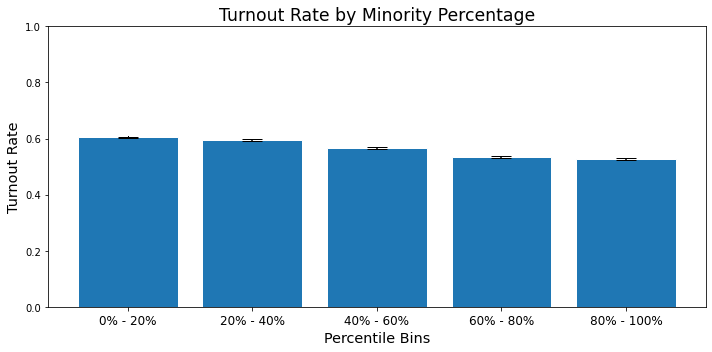

In [21]:
fig = plot_split('not_white', 'turnout', 5, 'Minority Percentage');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/minority_conditional_turnouts.png', clobber=True)
print_anova('not_white', 'turnout', n_bins=5, target='Median Household Income')

**Figure:** The above figure shows that there **were** significant differences between the turnout rate of counties with different minority percentages. The counties were split into five equally-sized bins, and their mean turnout rate was plotted. The chart shows a trend of decreasing turnout rate in counties with an increase in minority population.

# Machine Learning Analysis

The cells below contain the analyses that required the assistance of machine learning models. This includes two different clustering analyses, as well as two regression analyses.

## Plotting functions

These functions serve to make plotting results easier and more efficient, without requiring multiple lines of code each time.

In [0]:
def geoplot(gdf, col, cmap="viridis", title="", legend_title="", cbar_label="", cbar_fmt='%.2f', cbar=False, showfig=True, fig=None, ax=None):
    """This function plots a continuous variable in a geopandas dataframe with 
    an appropriately sized colorbar adjacent to it.

    Arguments
    ---------------------------------------------------------------------------
    gdf: this is the geopandas dataframe
    col: this ithe column to be plotted
    cmap: this is the colormap to be used in the plot
    title: this is the title that is to be given to the plot
    legend_title: this is the title to be given to the colorbar
    cbar_fmt: this it the number formatting to be applied to the colorbar
    cbar: {False, 'limit', 'normed', (tuple)}
        -False: the colorbar will have a min and max value equal to the min and max of the data
        -'limit': the colorbar will have a min and max value equal to the 98th and 2nd percentiles of the data
        -'normed': the colorbar will be limited to the range [0, 1]
        -(vmin, vmax): explicit values for vmin and vmax
    """

    # Make figure, axis, and plot it
    if not fig:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Add colorbar of appropriate size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    if cbar==False:
        min_lim, max_lim = min(gdf[col]), max(gdf[col])
    elif cbar=="limit":
        tot = len(gdf[col])
        min_lim, max_lim = list(gdf[col].sort_values())[int(tot*0.02)], list(gdf[col].sort_values())[int(tot*0.98)]
    elif cbar=="normed":
        min_lim, max_lim = 0, 1
    else:
        min_lim, max_lim = cbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_lim, vmax=max_lim))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, format=cbar_fmt)
    cbar.ax.set_title(legend_title)
    cbar.set_label(cbar_label, labelpad=20, rotation=270, fontsize='large')

    # Plot the data
    gdf.plot(col, ax=ax, cmap=cmap, vmin=min_lim, vmax=max_lim);

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Label
    ax.set_title(title, fontsize='xx-large')
    if showfig:
        fig.show();
        fig.tight_layout();

    return fig, ax

In [0]:
def geoplot_categorical(gdf, col, title="", legend_kwds={'loc':'lower left', 'bbox_to_anchor':(0, 0), 'fontsize':'small'}, show_legend=True, fig=None, ax=None):
    """This function plots a categorical variable in a geopandas dataframe with 
    an appropriately sized colorbar adjacent to it.

    Arguments
    ---------------------------------------------------------------------------
    gdf: this is the geopandas dataframe
    col: this ithe column to be plotted
    title: this is the title that is to be given to the plot
    legend_kwds: these are matplotlib legend keywords to describe the legend
        -'loc'
        -'bbox_to_anchor'
        -'fontsize'
    """
    # Make figure, axis, and plot it
    if not fig:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    gdf.plot(col, ax=ax, categorical=True, legend=True, cmap='viridis', legend_kwds=legend_kwds);

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Convert labels to integers if possible
    for lbl in ax.get_legend().get_texts():
        label_text = lbl.get_text()
        try:
            lbl.set_text(int(float(label_text)))
        except:
            pass
    if not show_legend:
        ax.get_legend().remove()

    # Label
    ax.set_title(title, fontsize='xx-large')
    fig.tight_layout()
    fig.show();

    return fig, ax

## Clustering at the County Level (Desi)

**Question**

Were counties more likely to have similar turnout rates to other counties with:

* similar demographic composition or
* the same Voter ID law

</br>

**Method**

We will create two separate clusterings.

1. Using k-means clustering, partition the counties based on demographic features.
2. Partition the counties based on their Voter ID requirements (there are five categories, and thus five clusters).

These different clusterings can then be compared to one another using the Fowlkes-Mallows index to see how similar they are. The inertia for the clusterings (on the counties' respective turnout data) can also be calculated to see which clustering was better able to partition the county data.


### Partition the counties

We will use the elbow method to determine an appropriate number of clusters to use. 

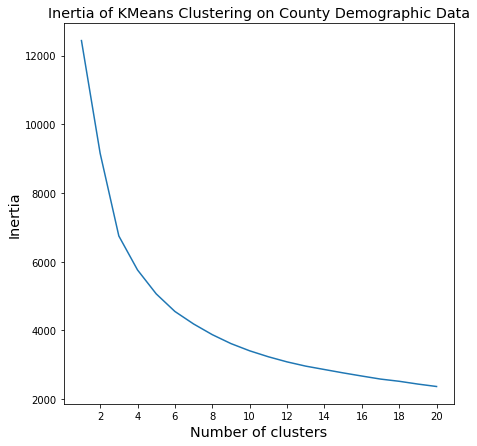

In [24]:
# Get the county-level demographic data 
clust_cnty_st = feat_st

# Run the K-means algorithm using k = 1 to 20 and observe the change in inertia
inertias = []
max_clust = 20
for n in range(1, max_clust+1):
    clust = KMeans(n_clusters=n, random_state=667).fit(clust_cnty_st)
    inertias.append(clust.inertia_)

# Plot the inertia as a function of the number of clusters
fig , ax = plt.subplots(figsize=(7, 7))
ax.plot(range(1, max_clust+1), inertias)
ax.set_title("Inertia of KMeans Clustering on County Demographic Data", fontsize='x-large')
ax.set_ylabel("Inertia", fontsize='x-large')
ax.set_xlabel("Number of clusters", fontsize='x-large')
ax.set_xticks(range(2, max_clust+1, 2))
ax.set_xticklabels(range(2, max_clust+1, 2));

**Figure:** By observing the decreasing inertia of the clusters, it is not explicitly clear that a certain *k* is optimal. The choice $k=5$ is an appropriate choice. This is also equal to the number of Voter ID Law categories that exist in state legistatures.

In [0]:
# Partition the data using the selected number of clusters
clust_1 = KMeans(n_clusters=5, random_state=667).fit(clust_cnty_st)

### Plot each cluster

We can plot the each county, using the cluster assignment as the colormap. This may provide insights as to how the demographic regions are located geographically.

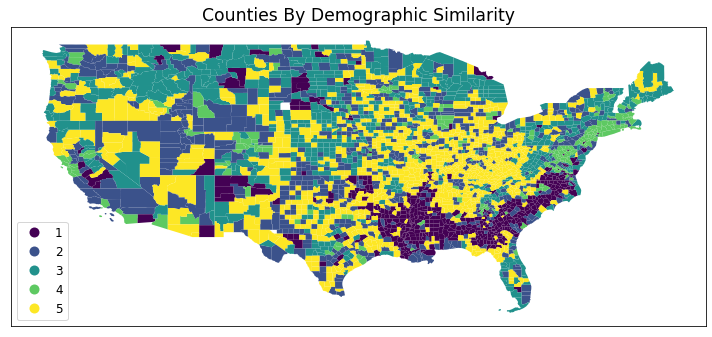

In [26]:
data_no_ak['cluster'] = clust_1.predict(clust_cnty_st)
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster.astype(int) + 1

fig, ax = geoplot_categorical(data_mainland, 'cluster', title="Counties By Demographic Similarity", legend_kwds={'loc':'lower left','fontsize':'large'})
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/clusters.png');

**Figure:** This figure shows a plot of all counties, categorized by their demographic similarity. Counties were split into 5 clusters, where they were grouped by the similarity in their demographic makeup.

In [27]:
print('The inertia of this clustering is {0:.0f}.'.format(clust_1.inertia_))

The inertia of this clustering is 5060.


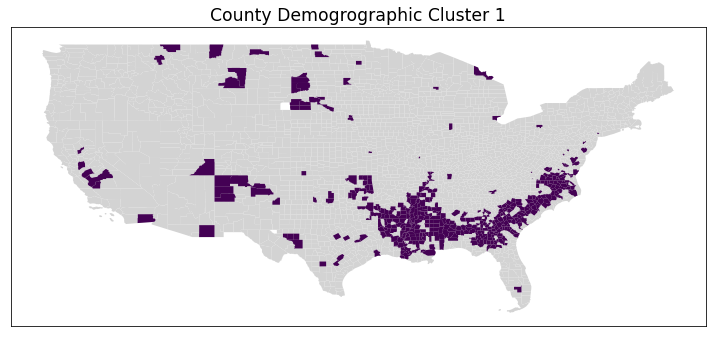

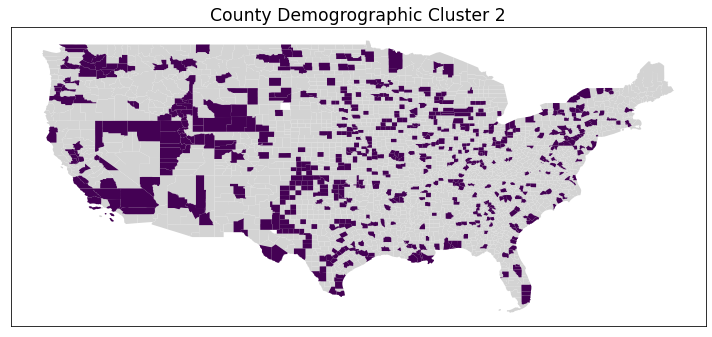

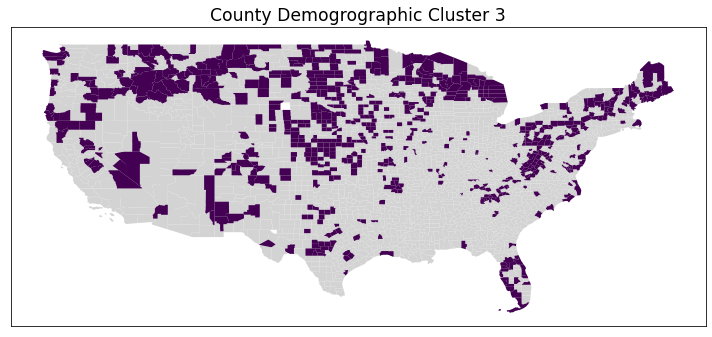

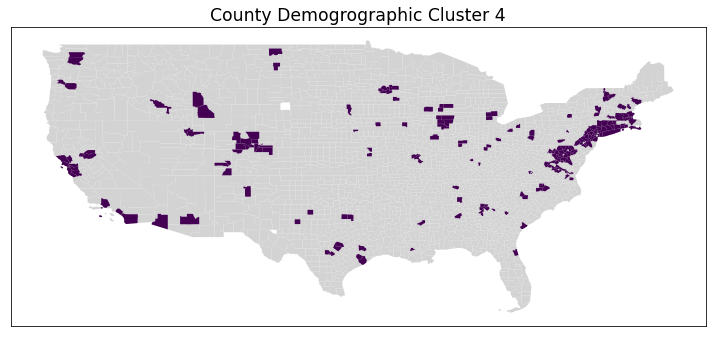

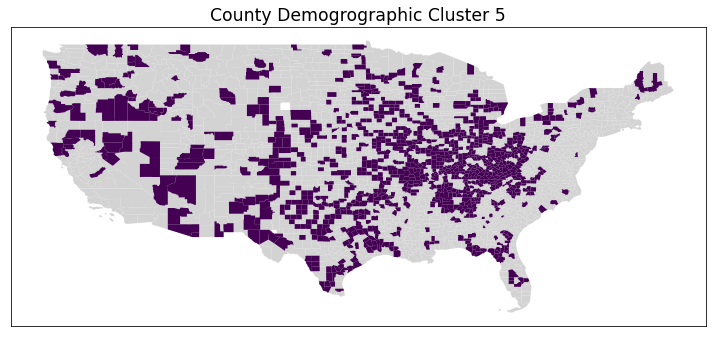

In [28]:
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster

for i in range(clust_1.n_clusters):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_mainland.plot(color='lightgray', ax=ax)
    fig, ax = geoplot_categorical(data_mainland[data_mainland['cluster'] == i], 'cluster', title="County Demogrographic Cluster {0}".format(i+1), fig=fig, ax=ax, show_legend=False)
    fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/cluter_{0}.png'.format(i+1))

**Figure:** The above figures show each demographic cluster plotted exclusively. This is helpful to distinguish where similar counties are located. Cluster 1 is overwhelmingly represented by counties in the southern half of the United States. Cluster 2 is very sporadic and not unique to any distinguishable geographic region. Cluster 3 is more sporadic, yet contains many of the northern-most counties, as well as some in the central region of the United States and in Florida. Cluster 4 is most heavily dominated by urban population centers; counties along the Northeastern seaboard (Boston, NYC, Philadelphia, DC) and west coast (San Francisco, LA) make up this cluster. Lastly, cluster 5 is widespread across America, with most of the counties in the Midwest (Ohio, Michigan, Wisconsin, Iowa, Missouri) falling into this group.

### Plot the Voter ID Laws of each cluster

We can now plot the Voter ID laws of the counties of each cluster and see if there is a noticeable pattern.

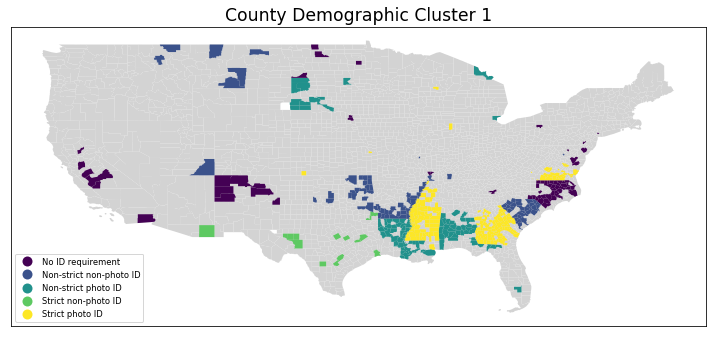

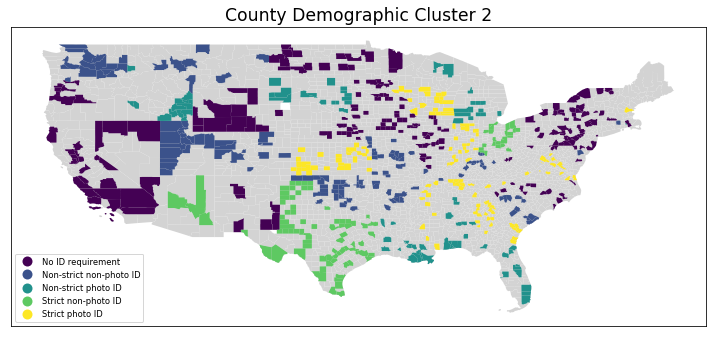

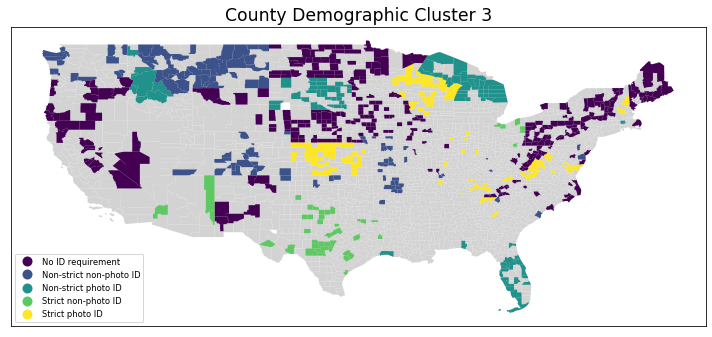

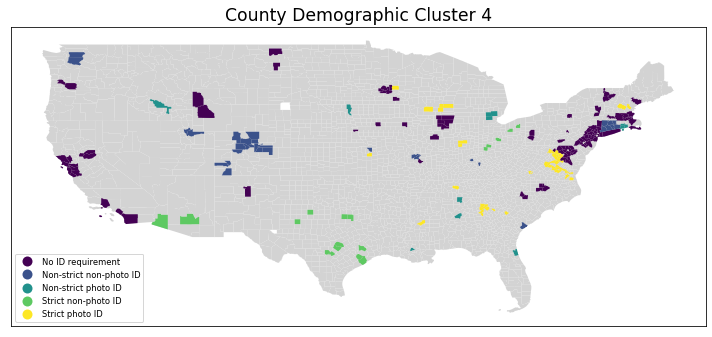

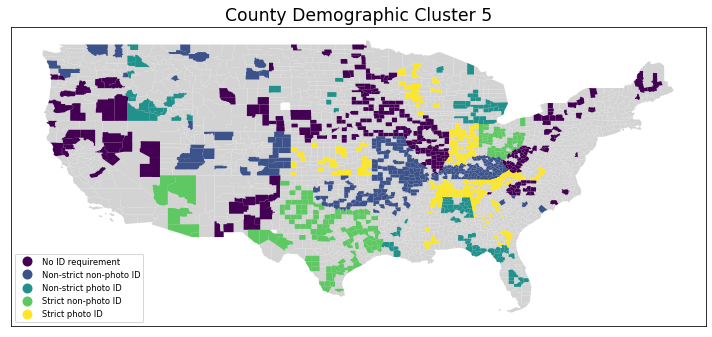

In [29]:
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster

for i in range(clust_1.n_clusters):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_mainland.plot(color='lightgray', ax=ax)
    geoplot_categorical(data_mainland[data_mainland['cluster'] == i], 'VoterIDL_1', title="County Demographic Cluster {0}".format(i+1), fig=fig, ax=ax)
    fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/idlaw_cluter_{0}.png'.format(i+1))

**Figure:** The figures above display the Voter ID Requirements of the counties in each deomgraphic cluster. Each Voter ID law is well represented among all 5 clusters. This is likely because Voter ID laws are established at the state level, while the clusters were formed at the county level. Demographics are not homogeneous across all counties in a state, leading to there being at least a couple of counties from each demographic cluster in most states.

Null hypothesis: The samlpes have the same mean voter ID strictness 

p-value for 0.0500 significance: 2.65e-24
we reject the null hypothesis



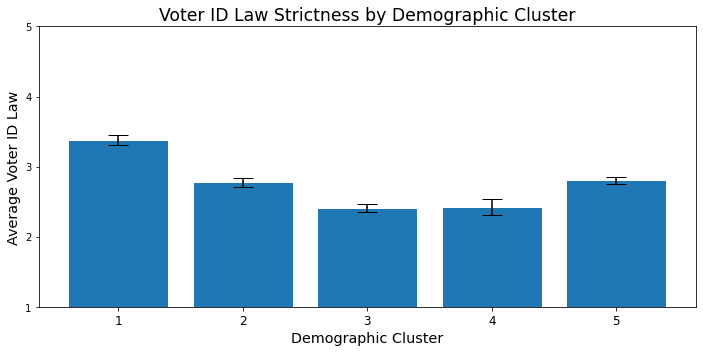

In [68]:
fig = plot_split('cluster', 'VoterIDLaw', n_bins=False, xlabel='Demographic Cluster')
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/idlaw_anova.png', clobber=True)

print_anova('cluster', 'VoterIDLaw', n_bins=False, target="voter ID strictness")

**Figure:** The above figure shows that there **were** significant differences between the Voter ID laws between the five demographic county clusters. The cluster with the strictest requirements was cluster 1, which we discovered was comprised of mostly southern counties. Clusters 3 and 4 (which we discovered contained mostly northern and urban counties, respectively) had the most relaxed Voter ID requirements.

### Plot the Voter Turnout of each cluster

We can now plot the turnout rate of the counties of each cluster and see if there is a noticeable pattern.

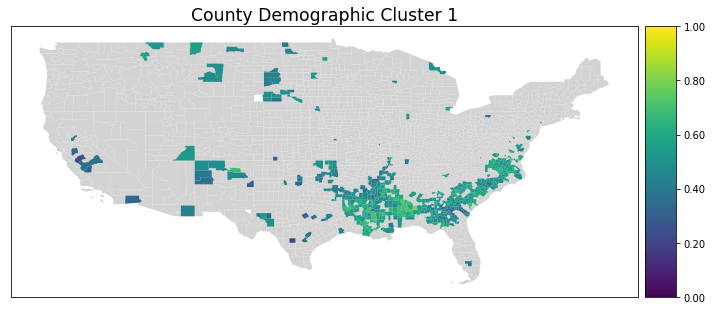

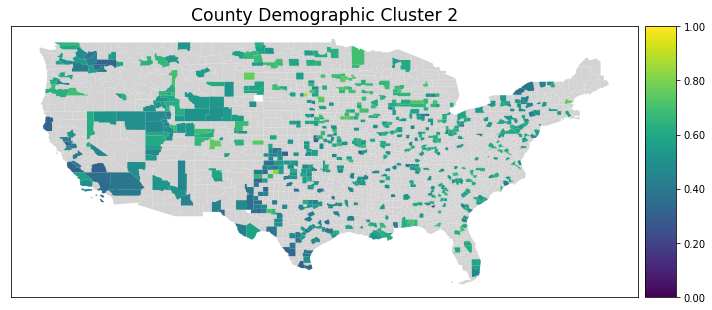

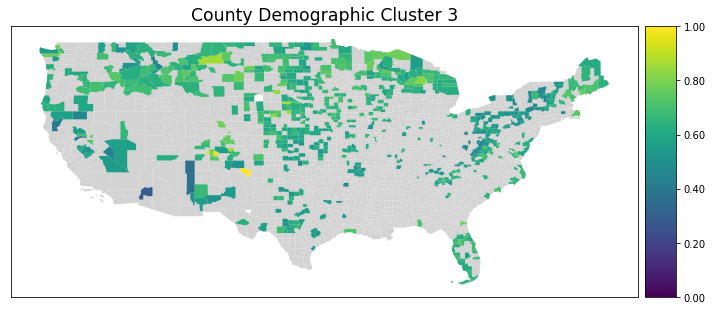

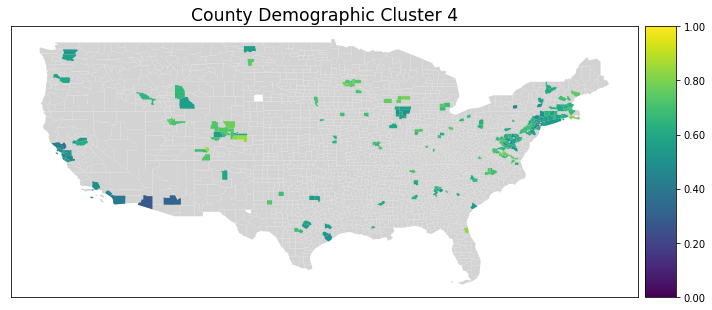

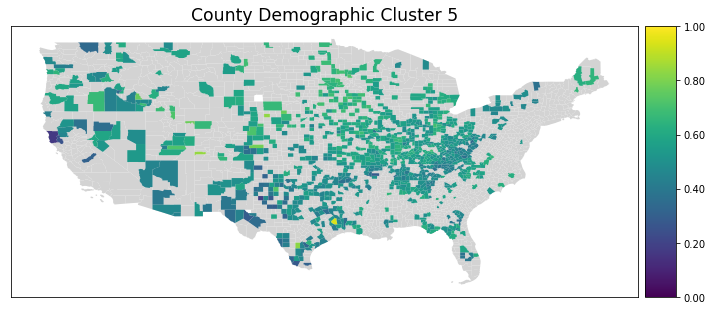

In [31]:
data_mainland['cluster'] = data_no_ak[data_no_ak.state_abbr != 'HI'].cluster

for i in range(clust_1.n_clusters):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_mainland.plot(color='lightgray', ax=ax)
    geoplot(data_mainland[data_mainland['cluster'] == i], 'turnout', title="County Demographic Cluster {0}".format(i+1), cbar="normed", fig=fig, ax=ax)
    fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/turnout_cluter_{0}.png'.format(i+1))

**Figure:** From these figures, it is not very clear if there is a relationship between the demographic clusters and voter turnout.

Null hypothesis: The samlpes have the same mean turnout rate 

p-value for 0.0500 significance: 2.72e-135
we reject the null hypothesis



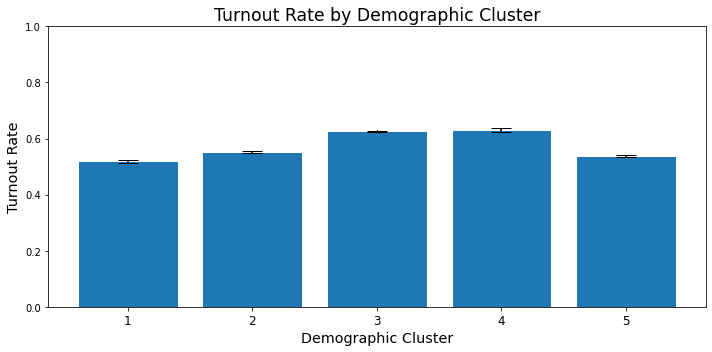

In [32]:
fig = plot_split('cluster', 'turnout', n_bins=False, xlabel='Demographic Cluster')
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/turnout_anova.png', clobber=True)

print_anova('cluster', 'turnout', n_bins=False, target="turnout rate")

**Figure:** The above figure shows that there **were** significant differences between the Voter ID laws between the five demographic county clusters. Clusters 1 and 5 had the lowest turnout rates. Cluster 1 was also found to have the strictest Voter ID requirements. Clusters 3 and 4 (which we discovered contained mostly northern and urban counties, respectively) had the highest turnout rates. We also noted in the previous chart that these clusters had the most relaxed Voter ID requirements.

Null hypothesis: The samlpes have the same mean turnout rate 

p-value for 0.0500 significance: 3.49e-44
we reject the null hypothesis



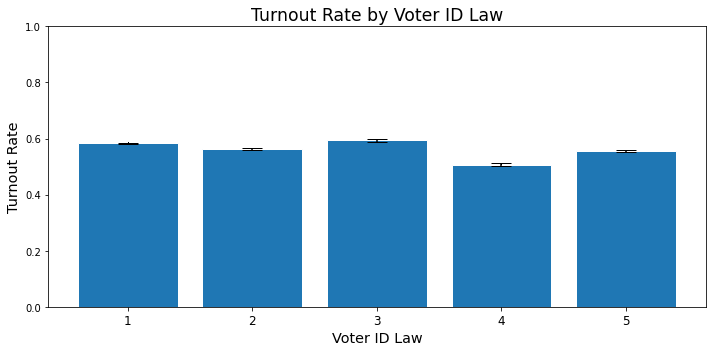

In [70]:
fig = plot_split('VoterIDLaw', 'turnout', n_bins=False, xlabel='Voter ID Law')
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/county demographic clusters/turnout_anova_idlaw.png', clobber=True)
print_anova('VoterIDL_1', 'turnout', n_bins=False, target="turnout rate")

**Figure:** The above figure shows that there **were** significant differences between the the turnout rates of counties subject to different Voter ID laws. However, the turnout rate does not show a trend; the turnout rate does not appear to exclusively decrease or increase with a change in the Voter ID requirement.

### Compare the demographic clusters to the Voter ID Law clusters

#### Compare the clusters using the Fowlkes-Mallows Index

"The [Fowlkes-Mallows Score](https://www.geeksforgeeks.org/ml-fowlkes-mallows-score/) is an evaluation metric to evaluate the similarity among clusterings obtained after applying different clustering algorithms." This value can range from 0, indicating the most dissimilarity between clusterings, to 1, indicating exactly identical clusterings.

In [34]:
idlaws = data_no_ak.dropna().VoterIDLaw

fmi = fowlkes_mallows_score(clust_1.labels_, idlaws)
print('\nFowlkes Mallows Index: {0:.3f}'.format(fmi))


Fowlkes Mallows Index: 0.244


The Fowlkes Mallows index for the demographic clustering vs. the Voter ID law clustering was low, which indicates that these two clusters are not very similar.

#### Compare the clusters using their inertia

The **inertia** of a clustering is the sum of squared intra-cluster distances. Smaller values are more desirable, as they indicate that the set is composed of partitions the maximize the similarity between observations. Our clusterings both have the same number of partitions, so this is an acceptable metric to use.

In [0]:
def inertia(df, labels):
    inertia = 0
    for c in np.unique(labels):
        sub = df.values[labels == c]
        mu = sub.mean(axis=0)
        inertia += ((sub - mu)**2).sum()
    return inertia

In [36]:
dem_inertia = inertia(target, clust_1.labels_)
idlaw_inertia = inertia(target, idlaws)
print('\033[1mInertia on Turnout\033[0m')
print('Demographic clustering: {0:.3e}'.format(dem_inertia))
print('Voter ID Law clustering: {0:.3e}'.format(idlaw_inertia))
print('Voter ID / Demographic: {0:.3}'.format(idlaw_inertia / dem_inertia))

Inertia on Turnout
Demographic clustering: 2.372e+01
Voter ID Law clustering: 2.717e+01
Voter ID / Demographic: 1.15


When observing the inertia of each clustering on the turnout rates of the counties, the demographic clustering a higher value 1.15 times smaller than the Voter ID law clustering. This supports the claim that counties were more likely to have turnout rates similar to other counties with the same demographic makeup than they were to have similar turnout rates to outher counties with the same Voter ID law.

## Clustering at the State Level (Furkan)

**Question**

Were states more likely to have similar turnout rates to other states with:

* similar demographic composition or
* the same Voter ID law

</br>

**Method**

We will create two separate clusterings.

1. Using k-means clustering, partition the states based on demographic features.
2. Partition the states based on their Voter ID requirements (there are five categories, and thus five clusters).

These different clusterings can then be compared to one another using the Fowlkes-Mallows index to see how similar they are. The inertia for the clusterings (on the states' respective turnout data) can also be calculated to see which clustering was better able to partition the county data.


### Partition the states

We will use the elbow method to determine an appropriate number of clusters to use. Furthermore, we would like to see if the data is best separated by 5 clusters, which is the same number of different Voter ID categories.

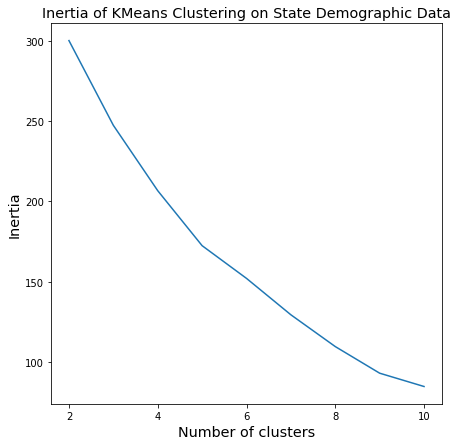

In [37]:
# Use clust_state_st as the data to cluster on
clust_state_st = feat_states_st.drop(columns=['VoterIDLaw', 'turnout', 'VoterIDL_1'])

# Run the K-means algorithm using k = 1 to 20 and observe the change in inertia
inertias = []
max_clust = 10
for n in range(2, max_clust+1):
    clust = KMeans(n_clusters=n, random_state=667).fit(clust_state_st)
    inertias.append(clust.inertia_)

# Plot the inertia as a function of the number of clusters
fig , ax = plt.subplots(figsize=(7, 7))
ax.plot(range(2, max_clust+1), inertias)
ax.set_title("Inertia of KMeans Clustering on State Demographic Data", fontsize='x-large')
ax.set_ylabel("Inertia", fontsize='x-large')
ax.set_xlabel("Number of clusters", fontsize='x-large')
ax.set_xticks(range(2, max_clust+1, 2))
ax.set_xticklabels(range(2, max_clust+1, 2));
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/state demographic cluster/elbow.png')

**Figure:** By observing the decreasing inertia of the clusters, it is not explicitly clear that a certain *k* is optimal. The choice $k=5$ is an appropriate choice. This is also equal to the number of Voter ID Law categories that exist in state legistatures.

### Plot each cluster

We can plot the each state, using the cluster assignment as the colormap. This may provide insights as to how the demographic regions are located geographically.

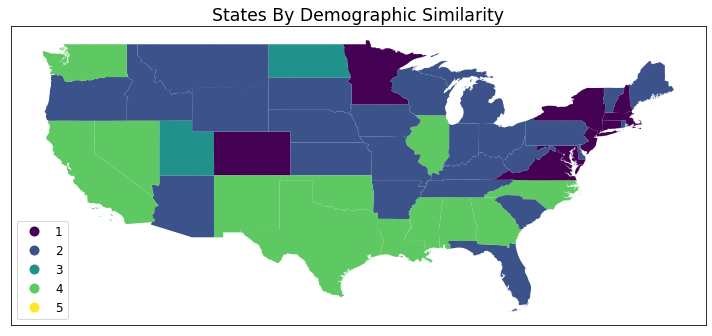

In [38]:
clust_1 = KMeans(n_clusters=5, random_state=667).fit(clust_state_st)
feat_states['cluster'] = clust_1.predict(clust_state_st) + 1
feat_states_mainland = feat_states[feat_states.index != 15]

votgeo_mainland = votgeo_mainland.sort_values(by='STATEFP')
votgeo_mainland['cluster'] = feat_states[feat_states.index != 15].cluster.values

fig, ax = geoplot_categorical(votgeo_mainland, 'cluster', title="States By Demographic Similarity", legend_kwds={'loc':'lower left','fontsize':'large'})
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/state demographic cluster/clusters.png', clobber=True);

**Figure:** This figure shows a plot of all states, categorized by their demographic similarity. States were split into 5 clusters, where they were grouped by the similarity in their demographic makeup. Note that tge District of Columbia is the only state in cluster 5

### Plot the Voter ID Laws of each cluster

We can now plot the Voter ID laws of the states of each cluster and see if there is a noticeable pattern.

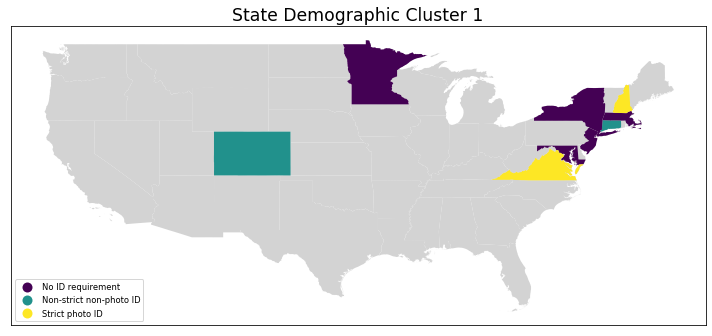

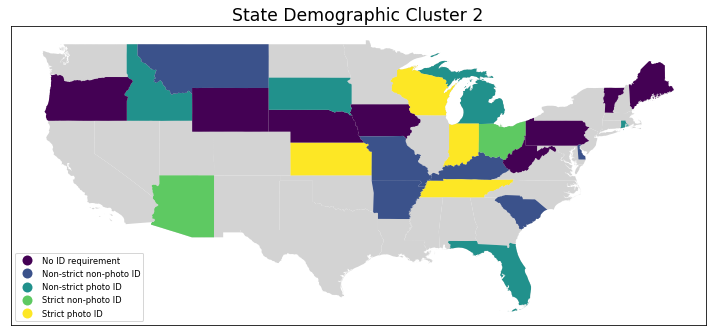

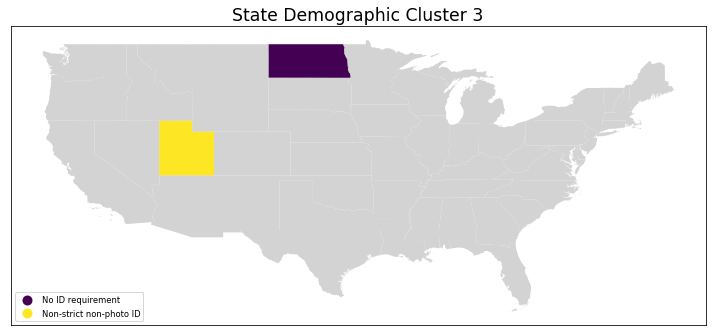

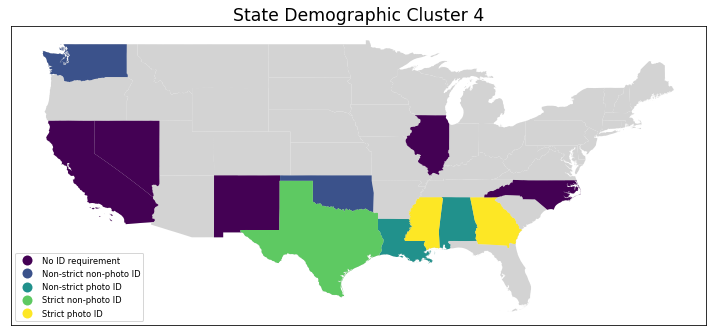

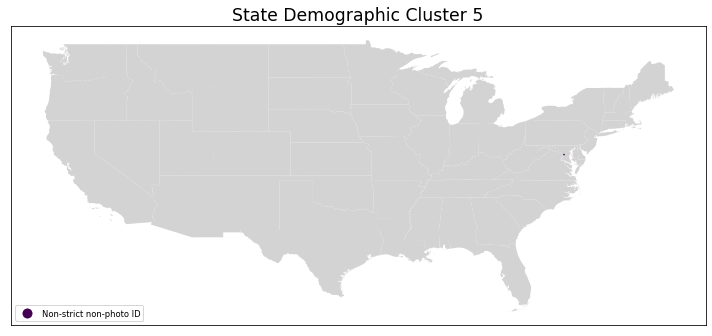

In [39]:
 for i in range(clust_1.n_clusters):
    fig, ax = plt.subplots(figsize=(10, 10))
    votgeo_mainland.plot(color='lightgray', ax=ax)
    geoplot_categorical(votgeo_mainland[votgeo_mainland['cluster'] == i+1], 'VoterIDL_1', title="State Demographic Cluster {0}".format(i+1), fig=fig, ax=ax)
    fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/state demographic cluster/idlaw_cluster_{0}.png'.format(i), clobber=True)

**Figure:** The figures above show the Voter ID Requirements of the states in each deomgraphic cluster. Overall, it is possible to say that the state voter ID laws are not aligned with state demographics because each cluster contains multiple voter ID law categories (except for the last cluster, which only contains one state).

Null hypothesis: The samlpes have the same mean Voter ID strictness 

p-value for 0.0500 significance: 8.89e-01
we fail to reject the null hypothesis



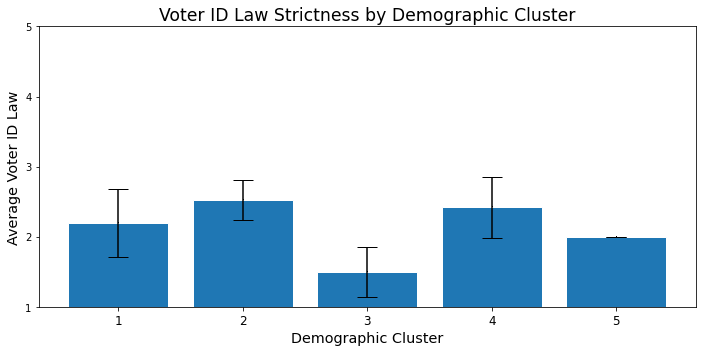

In [67]:
fig = plot_split('cluster', 'VoterIDLaw', n_bins=False, xlabel='Demographic Cluster', df=feat_states)
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/state demographic cluster/turnout_by_cluster.png', clobber=True)
print_anova('cluster', 'VoterIDLaw', n_bins=False, target='Voter ID strictness', alpha=0.05, df=feat_states)

**Figure:** The above figure shows that there were **not** significant differences between the Voter ID laws between the five demographic state clusters. The cluster with the strictest requirements waere clusters 2 and 4. Cluster 3 had the most relaxed Voter ID laws.

Null hypothesis: The samlpes have the same mean turnout rate 

p-value for 0.0500 significance: 4.68e-01
we fail to reject the null hypothesis



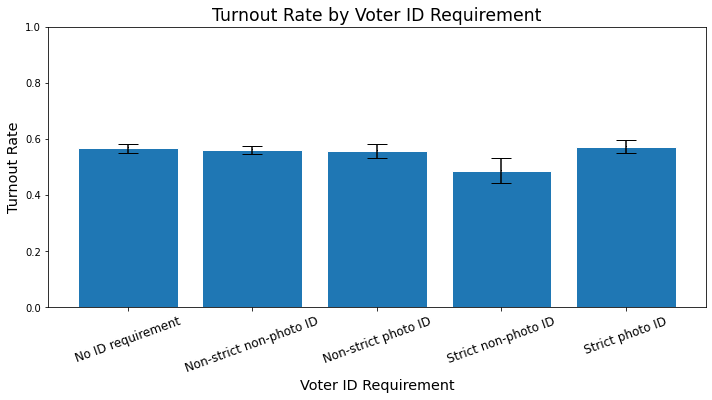

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = plot_split('VoterIDL_1', 'turnout', n_bins=False, xlabel='Voter ID Requirement', fig=fig, ax=ax, df=feat_states)
ax.set_xticklabels(data_no_ak.VoterIDL_1.unique(), rotation=20)
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/conditionals/idlaw_conditional_turnouts.png', clobber=True)
print_anova('VoterIDLaw', 'turnout', n_bins=False, target='turnout rate', df=feat_states)

**Figure:** The above figure shows that there **were** significant differences between the the turnout rates of states with different Voter ID laws. However, the turnout rate does not show a trend; the turnout rate does not appear to exclusively decrease or increase with a change in the Voter ID requirement. This is in line with our findings at the county level.

### Compare the demographic clusters to the Voter ID Law clusters

#### Compare the clusters using the Fowlkes-Mallows index

In [42]:
idlaws = feat_states.VoterIDLaw
fmi = fowlkes_mallows_score(clust_1.labels_, idlaws)
print('Fowlkes Mallows Index: {0:.3f}'.format(fmi))

Fowlkes Mallows Index: 0.243


The Fowlkes Mallows index for the demographic clustering vs. the Voter ID law clustering was low, which indicates that these two clusters are not very similar.

#### Compare the clusters using their inertia

In [43]:
dem_inertia = inertia(target_states, clust_1.labels_)
idlaw_inertia = inertia(target_states, idlaws)
print('\033[1mInertia on Turnout\033[0m')
print('Demographic clustering: {0:.3e}'.format(dem_inertia))
print('Voter ID Law clustering: {0:.3e}'.format(idlaw_inertia))
print('Voter ID / Demographic: {0:.3}'.format(idlaw_inertia / dem_inertia))

Inertia on Turnout
Demographic clustering: 2.171e-01
Voter ID Law clustering: 2.236e-01
Voter ID / Demographic: 1.03


When observing the inertia of each clustering on the turnout rates of the states, the demographic clustering a higher value 1.07 times smaller than the Voter ID law clustering. This supports the claim that states were more likely to have turnout rates similar to other states with the same demographic makeup than they were to have similar turnout rates to outher states with the same Voter ID law.

## Predicting Turnout Rates

**Question**

Are we able to predict the turnout rate of a given county based on its demographic features and the Voter ID law its citizens are subject to? Which features are the most important in making these predictions?

</br>

**Method**

We will create two separate models:

1. Random Forest regressor
2. Stochastic Gradient Descent

These two models can then be compared based on their mean square error (MSE) and mean absolute error (MAE) on a test set. We will also be able to extract feature importances after the models are created to see what influenced their decisions.

### Random Forest (Grace)

In [44]:
# -- select the parameter(s) to tune and the values to try
tuned_parameters = [{"min_samples_leaf" : [1, 2, 5, 10, 15, 20, 30, 50, 100, 200]}]

# -- perform Grid Search
rd_tune = RandomForestRegressor(random_state=667)
cv_tune = GridSearchCV(rd_tune, tuned_parameters)
cv_tune.fit(X_train, y_train)

# -- print out the params with the highest "score"
print(cv_tune.best_params_)

{'min_samples_leaf': 2}


In [45]:
# "Predict" the training data
y_pred_rf_train = cv_tune.predict(X_train)

# Unstandardize values
y_pred_rf_train_unst = y_pred_rf_train * target.std() + target.mean()
y_train_unst = y_train * target.std() + target.mean()

# Validation on training data
print('\033[1mModel Performance on Training Set\033[0m',
      '\nMean Squared Error: {0:.4f}'.format(mean_squared_error(y_train_unst, y_pred_rf_train_unst)),
      '\nMean Absolute Error: {0:.2%}'.format(mean_absolute_error(y_train_unst, y_pred_rf_train_unst)))



# "Predict" the test data
y_pred_rf = cv_tune.predict(X_test)

# Unstandardize values
y_pred_rf_unst = y_pred_rf * target.std() + target.mean()
y_test_unst = y_test * target.std() + target.mean()

# Validation on test data
print('\n\n\033[1mModel Performance on Test Set\033[0m',
      '\nMean Squared Error: {0:.4f}'.format(mean_squared_error(y_test_unst, y_pred_rf_unst)),
      '\nMean Absolute Error: {0:.2%}'.format(mean_absolute_error(y_test_unst, y_pred_rf_unst)))

Model Performance on Training Set 
Mean Squared Error: 0.0009 
Mean Absolute Error: 2.10%


Model Performance on Test Set 
Mean Squared Error: 0.0041 
Mean Absolute Error: 4.88%


The mean squared error (MSE) and mean absolute error (MAE) on the training and test set was very similar, which suggests this model has very limited overfitting. The MAE on the testing set was 4.88%, which means on average, this model was able to predict the turnout rate of a county with a 4.88% error.

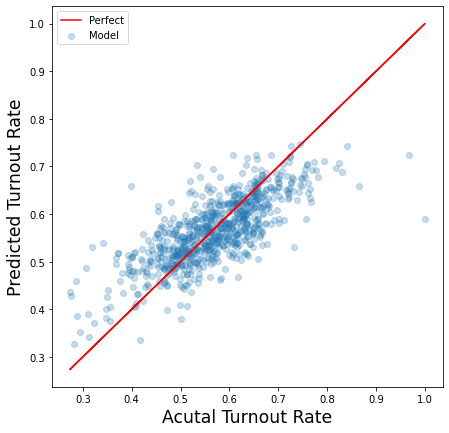

In [46]:
# -- comparison between prediction and real turn out rate
fig, ax = plt.subplots(figsize=(7, 7));
ax.scatter(y_test_unst, y_pred_rf_unst, alpha=0.25, label='Model')
ax.plot(y_test_unst, y_test_unst, 'r', label='Perfect')
ax.set_title('', fontsize='xx-large')
ax.set_ylabel('Predicted Turnout Rate', fontsize='xx-large')
ax.set_xlabel('Acutal Turnout Rate', fontsize='xx-large')
ax.legend()

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/Random Forest/pred_actually_turnout_test.png', clobber=True)
fig.show();

**Figure:** This chart shows the Random Forest model predictions vs the actual turnout rates. The red line represents a "perfect" fit. We can see that our predictions tend to this line quite well, and do so with similar variance for both low and high turnout rates. The only apparent outliers are for counties with turnout rates larger than 90%, which may even be erroneous data points in the testing set.

In [0]:
col_dict = {'34_younger':'Young\nPopulation',
            'MedianHous':'Median\nHousehold\nIncome',
            'unemployed':'Unemployed\n%',
            'CollegeDeg':'College\nDegree %',
            'not_white':'Minority %',
            '60_older':'Older\nPopulation',
            'MedianAge':'Median\nAge',
            '35_to_59':'Middle\nAged\nPopulation',
            'VoterIDLaw':'Voter ID\nLaw'}

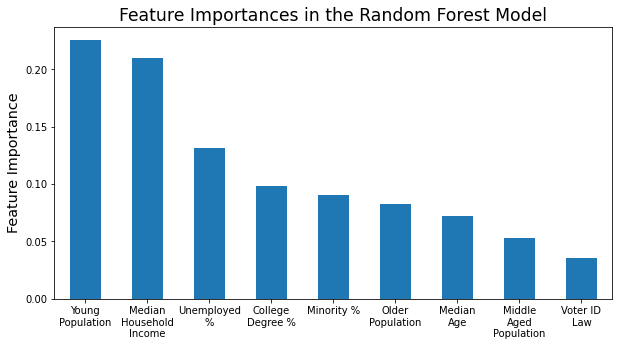

In [48]:
# -- put the feature importances into a DataFrame (n_estimators=100)
rf_imp = pd.DataFrame()
rf_imp["name"] = [col_dict[c] for c in X_train.columns]
rf_imp["importance"] = cv_tune.best_estimator_.feature_importances_
rf_imp

# -- sort by importance
rf_imp = rf_imp.sort_values("importance", ascending=False)

# -- make a bar chart of the most important features
fig, ax = plt.subplots(figsize=(10, 5))
rf_imp.plot("name", "importance", kind="bar", ax=ax, legend=None)
ax.set_xlabel("")
ax.set_ylabel("Feature Importance", fontsize='x-large')
plt.xticks(rotation=0)
ax.set_title('Feature Importances in the Random Forest Model', fontsize='xx-large')
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/Random Forest/feature_importance.png', clobber=True)
fig.show();

**Figure:** This figure shows the feature importances for the Random Forest model. `Young Population` and `Median Household Income` were the most important features in this model. It is also noticeable that the Voter ID Law was the third-least important feature in the SGD model.

### Stochastic Gradient Descent (Lan)

In [49]:
# -- Create and fit the SGD regression model
lm = SGDRegressor(random_state=667)
lm.fit(X_train.values.reshape(-1, 9), y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=667,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [50]:
# "Predict" the training data
y_pred_rf_train = lm.predict(X_train)

# Unstandardize values
y_pred_rf_train_unst1 = y_pred_rf_train * target.std() + target.mean()
y_train_unst1 = y_train * target.std() + target.mean()

# Validation on training data
print('\033[1mModel Performance on Training Set\033[0m',
      '\nMean Squared Error: {0:.4f}'.format(mean_squared_error(y_train_unst1, y_pred_rf_train_unst1)),
      '\nMean Absolute Error: {0:.2%}'.format(mean_absolute_error(y_train_unst1, y_pred_rf_train_unst1)))



# "Predict" the test data
y_pred_rf = lm.predict(X_test)

# Unstandardize values
y_pred_rf_unst1 = y_pred_rf * target.std() + target.mean()
y_test_unst1 = y_test * target.std() + target.mean()

# Validation on test data
print('\n\n\033[1mModel Performance on Test Set\033[0m',
      '\nMean Squared Error: {0:.4f}'.format(mean_squared_error(y_test_unst1, y_pred_rf_unst1)),
      '\nMean Absolute Error: {0:.2%}'.format(mean_absolute_error(y_test_unst1, y_pred_rf_unst1)))

Model Performance on Training Set 
Mean Squared Error: 0.0054 
Mean Absolute Error: 5.63%


Model Performance on Test Set 
Mean Squared Error: 0.0055 
Mean Absolute Error: 5.73%


The mean squared error (MSE) and mean absolute error (MAE) on the training and test set was very similar, which suggests this model has very limited overfitting. The MAE on the testing set was 5.73%, which means on average, this model was able to predict the turnout rate of a county with a 5.73% error.

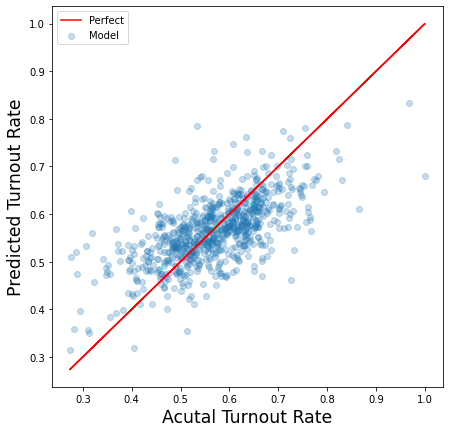

In [51]:
# -- comparison between prediction and real turn out rate
fig, ax = plt.subplots(figsize=(7, 7));
ax.scatter(y_test_unst1, y_pred_rf_unst1, alpha=0.25, label='Model')
ax.plot(y_test_unst1, y_test_unst1, 'r', label='Perfect')
ax.set_title('', fontsize='xx-large')
ax.set_ylabel('Predicted Turnout Rate', fontsize='xx-large')
ax.set_xlabel('Acutal Turnout Rate', fontsize='xx-large')
ax.legend()

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/Stochastic Gradient Descent/pred_actually_turnout_test.png', clobber=True)
fig.show();

**Figure:** This chart shows the SGD model predictions vs the actual turnout rates. The red line represents a "perfect" fit. We can see that our predictions tend to this line quite well, and do so with similar variance for both low and high turnout rates. 

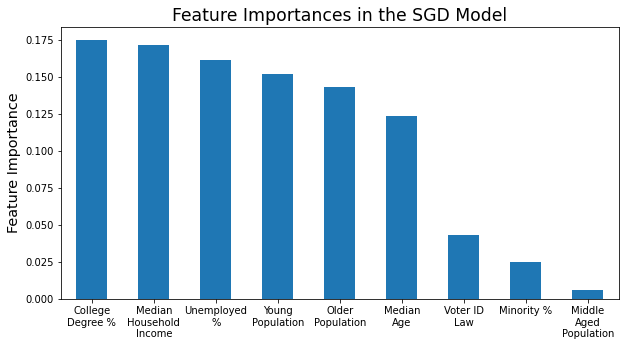

In [52]:
# -- put the feature importances into a DataFrame
lm_imp = pd.DataFrame()
lm_imp["name"] = [col_dict[c] for c in X_train.columns]
lm_imp["importance"] = abs(lm.coef_) / abs(lm.coef_).sum()
lm_imp

# -- sort by importance
lm_imp = lm_imp.sort_values("importance", ascending=False)

# -- make a bar chart of the most important features
fig, ax = plt.subplots(figsize=(10, 5))
lm_imp.plot("name", "importance", kind="bar", ax=ax, legend=None)
ax.set_xlabel("")
ax.set_ylabel("Feature Importance", fontsize='x-large')
plt.xticks(rotation=0)
ax.set_title('Feature Importances in the SGD Model', fontsize='xx-large')
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/Stochastic Gradient Descent/feature_importance.png', clobber=True)
fig.show();

**Figure:** This figure shows the feature importances for the Stochastic Gradient Descent model. `College Degree %` and `Median Household Income` were the most important features in this model, though `Unemployed %`, `Young Population`, `Older Population`, and `Median Age` were also very relevant features. It is also noticeable that the Voter ID Law was the third-least important feature in the SGD model.

### Compare Random Forest and SGD Models

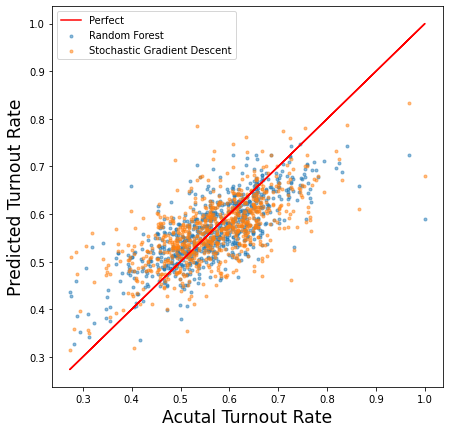

In [53]:
# -- comparison between prediction and real turn out rate
fig, ax = plt.subplots(figsize=(7, 7));
ax.scatter(y_test_unst, y_pred_rf_unst, marker='.', alpha=0.5, label='Random Forest')
ax.scatter(y_test_unst1, y_pred_rf_unst1, marker='.', alpha=0.5, label='Stochastic Gradient Descent')
ax.plot(y_test_unst, y_test_unst, 'r', label='Perfect')
ax.set_title('', fontsize='xx-large')
ax.set_ylabel('Predicted Turnout Rate', fontsize='xx-large')
ax.set_xlabel('Acutal Turnout Rate', fontsize='xx-large')
ax.legend()

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/rf_vs_sgd.png', clobber=True)
fig.show();

**Figure:** This chart shows the Random Forest and SGD model predictions vs the actual turnout rates. The red line represents a "perfect" fit. We can see that our predictions tend to this line quite well, and do so with similar variance for both low and high turnout rates. From this figure, it is not trivial whether one model has a better performance than the other.

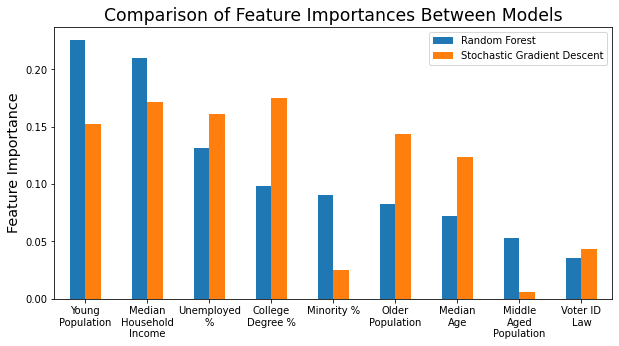

In [54]:
# Merge the importances of both models
feat_imp = rf_imp.merge(lm_imp, on='name', suffixes=('_rf', '_sgd'))

# Set position of bar on X axis
barWidth = 0.25
x1 = np.arange(len(feat_imp))
x2 = [x + barWidth for x in x1]

# -- make a bar chart of the most important features
fig, ax = plt.subplots(figsize=(10, 5))
feat_imp.plot.bar(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Feature Importance", fontsize='x-large')
ax.set_xticklabels(feat_imp.name)
plt.xticks(rotation=0)
ax.legend(['Random Forest', 'Stochastic Gradient Descent'])
ax.set_title('Comparison of Feature Importances Between Models', fontsize='xx-large')
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/rf_vs_sgd_feature_importance.png', clobber=True)
fig.show();

**Figure:** This figure shows the difference in feature importances between the Random Forest and Stochastic Gradient Descent models. The six top features in the SGD model all had roughly equal weights, while the Random Forest model has two features that are much more heavily weighted than the rest of the features. It is also noticeable that the Voter ID Law was the least important feature in the random forest model, and the third-least important feature in the SGD model.

In [55]:
# Random Forest validation
print('\033[1mRandom Forest\033[0m',
      '\nMean Squared Error: {0:.4f}'.format(mean_squared_error(y_test_unst, y_pred_rf_unst)),
      '\nMean Absolute Error: {0:.2%}'.format(mean_absolute_error(y_test_unst, y_pred_rf_unst)))

# SGD Validation
print('\n\n\033[1mStochastic Gradient Descent\033[0m',
      '\nMean Squared Error: {0:.4f}'.format(mean_squared_error(y_test_unst1, y_pred_rf_unst1)),
      '\nMean Absolute Error: {0:.2%}'.format(mean_absolute_error(y_test_unst1, y_pred_rf_unst1)))

Random Forest 
Mean Squared Error: 0.0041 
Mean Absolute Error: 4.88%


Stochastic Gradient Descent 
Mean Squared Error: 0.0055 
Mean Absolute Error: 5.73%


From the above metrics, it is more clear that the Random Forest model is better able to predict the turnout rates of a county from its demographic makeup.